## Nesse exemplo, nós usaremos o gradiente descendente em batelada para entender a influência do passo de aprendizagem em seu desempenho e convergência.

In [67]:
# Import all necessary libraries
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import random

In [68]:
# Always reset the pseudo-random numbers generator to a known value so that your results are always the same.
seed = 1234
np.random.seed(seed)

### Definição de funções úteis.

In [69]:
def calculateErrorSurface(X, y):
    """Generate data points for plotting the error surface."""
    # Get the number of examples.
    N = len(y)

    # Generate values for parameters.
    M = 200
    a1 = np.linspace(-20.0, 24.0, M)
    a2 = np.linspace(-20.0, 24.0, M)

    # Generate the mesh grid.
    A1, A2 = np.meshgrid(a1, a2)

    # Get the attributes
    x1 = X[:,0].reshape(N, 1)
    x2 = X[:,1].reshape(N, 1)

    # Generate points for plotting the cost-function surface.
    J = np.zeros((M, M))
    for iter1 in range(0, M):
        for iter2 in range(0, M):
            # Hypothesis function.
            yhat = A1[iter1, iter2]*x1 + A2[iter1, iter2]*x2
            # Calculate the MSE.
            J[iter1, iter2] = (1.0/N)*np.sum(np.square(y - yhat))

    return J, A1, A2

def calculateClosedFormSolution(X, y):
    """Calculate closed-form solution using the normal equation."""
    # Get the number of examples.
    N = len(y)
    # Closed-form solution.
    a_opt = np.linalg.pinv(np.transpose(X).dot(X)).dot(np.transpose(X).dot(y))
    yhat = X.dot(a_opt)
    Joptimum = (1.0/N)*np.sum(np.power((y - yhat), 2))

    return Joptimum, a_opt

# Implementação do gradiente descendente em batelada.
def batchGradientDescent(X, y, alpha, maxNumEpoch):
    '''Function implementing the batch version of the gradient descent.'''

    # Get the number of training examples.
    N = len(y)

    # Create empty structures.
    a_hist = np.zeros((2, maxNumEpoch))
    Jgd = np.zeros(maxNumEpoch)

    # Intialize the weights.
    a = np.array([-20.0, -20.0]).reshape(2, 1)

    # Intialize weights history.
    a_hist[:, 0] = a.reshape(2,)

    # Calculate the error for the initial weights.
    yhat = X.dot(a)
    Jgd[0] = (1.0/N)*np.sum(np.power(y[:,0] - yhat[:,0], 2))

    # Initialize gradient history matrix with zeros.
    grad_hist = np.zeros((2, maxNumEpoch))

    # Error between consecutive epochs.
    error = 1
    # Epoch counter.
    epoch = 0
    # Batch gradient-descent loop.
    while(error > 1e-5 and epoch < maxNumEpoch-1):

        # Hypothesis function.
        yhat = X.dot(a)

        # Calculate gradient vector.
        gradients = -X.T.dot(y - yhat)

        # Weight update rule.
        a = a - alpha*gradients

        # Store weight variation.
        a_hist[:, epoch+1] = a.reshape(2,)

        # Calculate and store actual error.
        yhat = X.dot(a)
        Jgd[epoch+1] = (1.0/N)*np.sum(np.power(y[:,0] - yhat[:,0], 2))

        # Error difference between actual and previous epoch.
        error = np.abs(Jgd[epoch] - Jgd[epoch+1])

        # Update the gradient history.
        grad_hist[:, epoch] = gradients.reshape(2,)

        # Increment the epoch.
        epoch = epoch + 1

    return a, Jgd, a_hist, grad_hist, epoch

### Gerando a função observável.

A função objetivo é dada por
$$y = a_1 x_1 + a_2 x_2,$$
onde $a_1$ e $a_2$ são iguais a 1 e $x_1$ e $x_2$ são valores retirados da distribuição Gaussiana Normal Padrão.


A função observável é dada por
$$y_{noisy} = y + w,$$
onde $w$ é o ruído adicionado às amostras e segue a distribuição Gaussiana Normal Padrão.

A função hipótese que será usada é dada por
$$\hat{y} = h(\textbf{x}) = \hat{a}_1 x_1 + \hat{a}_2 x_2.$$

Quando consideramos todos os exemplos disponíveis, a função hipótese pode ser expressa em formato matricial como

$$\hat{\textbf{y}} = \textbf{X}\hat{\textbf{a}},$$

onde $\textbf{X}$ é a matriz de atributos, contendo em cada coluna os valores dos atributos, $\hat{\textbf{a}}$ é o vetor coluna contendo a aproximação dos pesos (i.e., $\hat{a}_1$ e $\hat{a}_2$) e $\hat{\textbf{y}}$ é um vetor coluna com as saídas para cada um dos exemplos em $\textbf{X}$.

In [70]:
# Number of pairs feature/label.
N = 10000

# Input values (features)
x1 = np.random.randn(N, 1)
x2 = np.random.randn(N, 1)

# True model.
y = x1 + x2

# Noise vector
w = np.random.randn(N, 1)

# Observable function.
y_noisy = y + w

Para podermos representar a função hipótese em seu formato matricial, precisamos criar a matriz de atributos.

No caso deste exemplo, devido à função hipótese não ter o peso $a_0$, ela é criada concatenando-se os dois vetores coluna de atributos, $x_1$ e $x_2$.

In [71]:
# Concatenate both column vectors, x1 and x2.
X = np.c_[x1, x2]

### Plotando as funções objetivo e observável

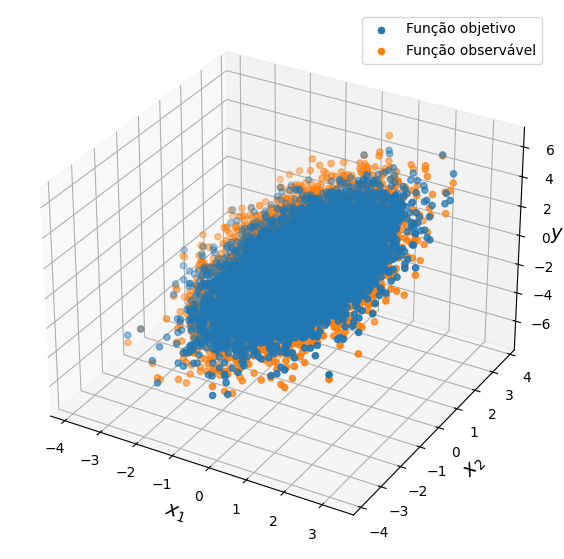

In [72]:
# Plot objective and observable functions.
fig = plt.figure(figsize=(7, 7))
plt.subplot(projection='3d')
ax = fig.gca()

ax.scatter(x1,x2,y, label='Função objetivo')
ax.scatter(x1,x2,y_noisy, label='Função observável')
ax.set_xlabel('$x_1$', fontsize=14)
ax.set_ylabel('$x_2$', fontsize=14)
ax.set_zlabel('$y$', fontsize=14)
ax.zaxis.labelpad=-4
plt.legend()
plt.show()

### Encontrando a solução ótima com a equação normal.

In [73]:
# Calculate the optimum weights.
Joptimum, a_opt = calculateClosedFormSolution(X, y_noisy)

# Print a1 and a2 weights.
print('peso a1:', a_opt[0, 0])
print('peso a2:', a_opt[1, 0])

# Plot the MSE.
print('Erro:', Joptimum)

peso a1: 1.0032994113858895
peso a2: 0.9999704951023055
Erro: 0.995225680139118


### Plotando a superfície de erro.

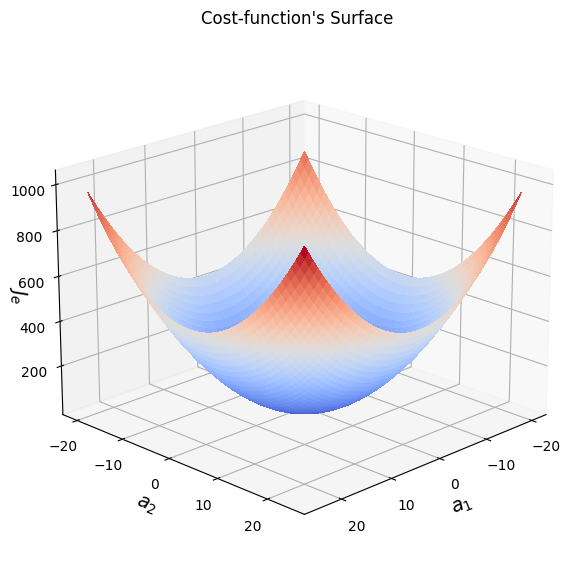

In [74]:
# Calculate the points to plot the error surface.
J, A1, A2 = calculateErrorSurface(X, y_noisy)

# Plot cost-function surface.
fig = plt.figure(figsize=(7,7))
plt.subplot(projection='3d')
ax = fig.gca()
surf = ax.plot_surface(A1, A2, J, cmap=cm.coolwarm, linewidth=0, antialiased=False)
ax.set_xlabel('$a_1$', fontsize=14)
ax.set_ylabel('$a_2$', fontsize=14)
ax.set_zlabel('$J_e$', fontsize=14);
plt.title('Cost-function\'s Surface')
ax.view_init(20, 45)
ax.zaxis.labelpad=-4
# Show the plot.
plt.show()

### Encontrando os pesos com o gradiente descendente.

A escolha do passo de aprendizagem é muito importante:

+ Caso ele seja **muito pequeno**, a convergência do algoritmo será lenta.
    + No caso do GD em batelada, se esperarmos tempo suficiente (i.e., épocas), ele irá convergir.
<br/><br/>

+ Caso ele seja **grande, mas não tão grande assim**, o algoritmo pode ficar **pulando** (ou **oscilando**) de um lado para o outro da superfície de erro até que, por sorte, ele converge.
<br/><br/>

+ Caso ele seja **muito grande**, o algoritmo irá divergir.
    + Ao invés de se aproximar do ponto de mínimo a cada época, ele se distancia cada vez mais.
    + Ao usar passos grandes, pode ocorrer um ciclo de *feedback* **positivo** que faz com que os gradientes e, consequentemente os pesos, aumentem rapidamente até que ocorra o estouro (*overflow*) da representação numérica.
<br/><br/>

+ Caso ele tenha o **tamanho ideal**, o processo de convergência é acelerado, permitindo que o algoritmo alcance o ponto de mínimo mais rapidamente.

In [75]:
maxNumEpoch = 10000

alpha = 0.000002

#alpha = 0.000002 # Too small learning rate.
#alpha = 0.00018  # Large learning rate, but it converges.
#alpha = 0.00022  # Too large learning rate.
#alpha = 0.0001   # Empirically found ideal learning rate.

# Batch gradient-descent solution.
a, Jgd, a_hist, grad_hist, epoch = batchGradientDescent(X, y_noisy, alpha, maxNumEpoch)

### Plotando a superfície de contorno e MSE em função das iterações.

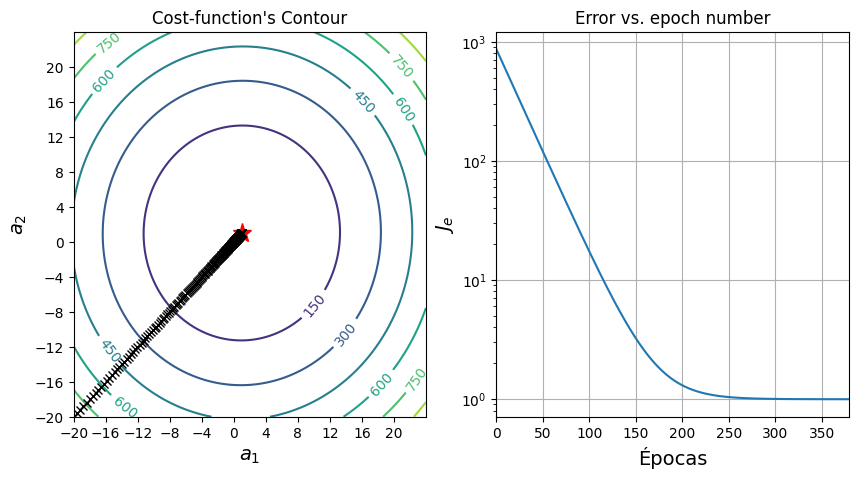

In [76]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

cp = ax1.contour(A1, A2, J)
ax1.clabel(cp, inline=1, fontsize=10)
ax1.set_xlabel('$a_1$', fontsize=14)
ax1.set_ylabel('$a_2$', fontsize=14)
ax1.set_title('Cost-function\'s Contour')
ax1.plot(a_opt[0], a_opt[1], c='r', marker='*', markersize=14)
ax1.plot(a_hist[0, 0:epoch], a_hist[1, 0:epoch], 'kx')
ax1.set_xticks(np.arange(-20, 24, step=4.0))
ax1.set_yticks(np.arange(-20, 24, step=4.0))

ax2.plot(np.arange(0, epoch), Jgd[0:epoch])
ax2.set_xlim((0, epoch))
ax2.set_yscale('log')
ax2.set_xlabel('Épocas', fontsize=14)
ax2.set_ylabel('$J_e$', fontsize=14)
ax2.set_title('Error vs. epoch number')
ax2.set_xlim(0, epoch-1)
ax2.grid()

plt.show()

### Plotando a variação do gradiente ao longo do treinamento

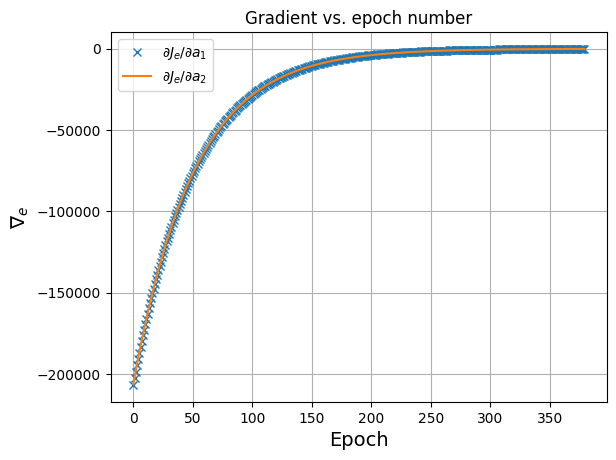

In [77]:
fig = plt.figure()

plt.plot(np.arange(0, epoch), grad_hist[0, 0:epoch], 'x', label='$ \partial J_{e} / \partial a_1$')
plt.plot(np.arange(0, epoch), grad_hist[1, 0:epoch], label='$ \partial J_{e} / \partial a_2$')
#plt.yscale('log')
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('$\\nabla_e$', fontsize=14)
plt.title('Gradient vs. epoch number')
plt.legend()
plt.grid()

plt.show()

### Conclusões

+ O valor do passo de aprendizagem deve ser **explorado** para se encontrar um valor ideal que **acelere** a convergência do algoritmo de **forma estável**.